## 20. 전이 학습을 통해 딥러닝의 성능 극대화하기

### 1. 소규모 데이터셋으로 만드는 강력한 학습 모델

치매 환자의 뇌인지 일반인의 뇌인지 예측하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 깃허브에 준비된 데이터 가져오기
!git clone https://github.com/taehojo/data-ch20.git

fatal: destination path 'data-ch20' already exists and is not an empty directory.


In [3]:
#학습셋의 변형 설정 부분
train_datagen = ImageDataGenerator(rescale=1./255,         # 주어진 이미지의 크기를 설정
                                  horizontal_flip=True,    # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동
                                  #rotation_range=5,        # 정해진 각도만큼 회전
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동
                                  #zoom_range=1.2,          # 확대 또는 축소
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만들기
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. 
                                                            # nearest 옵션은 가장 비슷한 색으로 채우게 된다.
                                  )      

train_generator = train_datagen.flow_from_directory(
'./data-ch20/train',              # 학습셋이 있는 폴더 위치
        target_size=(150,150),    # 이미지 크기
        batch_size=5,
        class_mode='binary')      # 치매/정상 이진 분류이므로 바이너리 모드로 진행

Found 160 images belonging to 2 classes.


In [4]:
# 테스트셋은 이미지 부풀리기 과정을 진행하지 않는다.
test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',        # 테스트셋이 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 120 images belonging to 2 classes.


In [5]:
# 앞서 배운 CNN 모델을 만들어 적용
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [7]:
! pip install SciPy   # 넘파이에 없는 딥한 기능들을 사용할 수 있다.

In [6]:
# 모델 실행 옵션 설정
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002), 
              metrics=['accuracy'])

# 학습의조기 중단 설정 
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = model.fit(
train_generator,
epochs=100,
validation_data=test_generator,
validation_steps=10,
callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 5s 113ms/step - loss: 0.7015 - accuracy: 0.4938 - val_loss: 0.6884 - val_accuracy: 0.6600
Epoch 2/100
32/32 [==============================] - 3s 104ms/step - loss: 0.6895 - accuracy: 0.5625 - val_loss: 0.6869 - val_accuracy: 0.7200
Epoch 3/100
32/32 [==============================] - 3s 100ms/step - loss: 0.6805 - accuracy: 0.5813 - val_loss: 0.6908 - val_accuracy: 0.4200
Epoch 4/100
32/32 [==============================] - 3s 108ms/step - loss: 0.6781 - accuracy: 0.6000 - val_loss: 0.6857 - val_accuracy: 0.4200
Epoch 5/100
32/32 [==============================] - 3s 98ms/step - loss: 0.6650 - accuracy: 0.5875 - val_loss: 0.6414 - val_accuracy: 0.6200
Epoch 6/100
32/32 [==============================] - 3s 102ms/step - loss: 0.6791 - accuracy: 0.6125 - val_loss: 0.6827 - val_accuracy: 0.4800
Epoch 7/100
32/32 [==============================] - 3s 106ms/step - loss: 0.6474 - accuracy: 0.6562 - val_loss: 0.6625 - val_accuracy: 0.5000


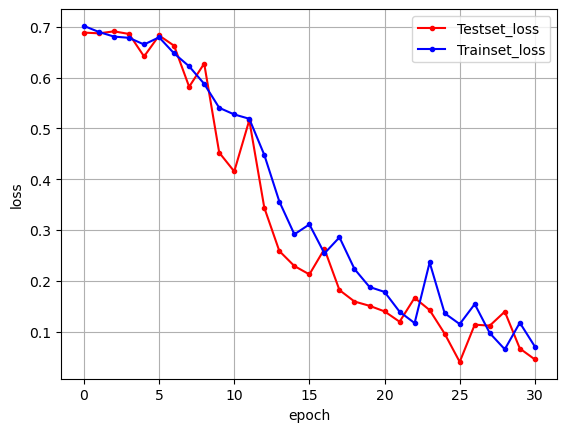

In [12]:
# 검증셋과 학습셋의 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

# 그래프에 그리드 주고 레이블 표시
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 2. 전이 학습으로 모델 성능 극대화하기

전이 학습 실습

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 깃허브에 준비된 데이터 가져오기
!git clone https://github.com/taehojo/data-ch20.git

fatal: destination path 'data-ch20' already exists and is not an empty directory.


In [3]:
# 학습셋의 변형을 설정해준다.
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip = True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  #rotation_range=5,
                                  #shear_range=0.7,
                                  #zoom_range=1.2,
                                  #vertical_flip=True,
                                  #fill_mode='nearest'
                                  )

train_generator = train_datagen.flow_from_directory(
'./data-ch20/train',
target_size=(150,150),
batch_size=5,
class_mode='binary')

# 테스트셋의 정구화 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
'./data-ch20/test',
target_size=(150,150),
batch_size=5,
class_mode='binary')

# VGG 모델 불러오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

# 모델 설정
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                             

In [4]:
# 모델의 옵션 설정
finetune_model.compile(loss='binary_crossentropy', 
                       optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단 설정
earlyPstopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = finetune_model.fit(
train_generator,
epochs=20,
validation_data=test_generator,
validation_steps=10,
callbacks=[earlyPstopping_callback])

Epoch 1/20
32/32 [==============================] - 24s 714ms/step - loss: 0.7076 - accuracy: 0.6187 - val_loss: 0.6003 - val_accuracy: 0.6400
Epoch 2/20
32/32 [==============================] - 22s 682ms/step - loss: 0.5581 - accuracy: 0.7063 - val_loss: 0.4666 - val_accuracy: 0.8600
Epoch 3/20
32/32 [==============================] - 21s 670ms/step - loss: 0.4808 - accuracy: 0.7750 - val_loss: 0.4108 - val_accuracy: 0.8000
Epoch 4/20
32/32 [==============================] - 20s 632ms/step - loss: 0.3837 - accuracy: 0.8750 - val_loss: 0.3933 - val_accuracy: 0.8200
Epoch 5/20
32/32 [==============================] - 19s 605ms/step - loss: 0.3602 - accuracy: 0.8750 - val_loss: 0.3393 - val_accuracy: 0.8600
Epoch 6/20
32/32 [==============================] - 18s 576ms/step - loss: 0.3335 - accuracy: 0.8750 - val_loss: 0.5184 - val_accuracy: 0.6400
Epoch 7/20
32/32 [==============================] - 19s 606ms/step - loss: 0.3535 - accuracy: 0.8250 - val_loss: 0.3317 - val_accuracy: 0.8600

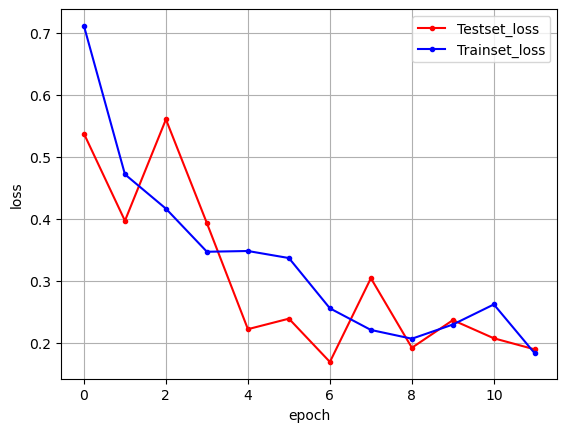

In [6]:
# 검증셋과 학습셋의 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()